<a id='home'></a>
### purpose

see how averaging across individuals affects perceived performance.

Use individual-level data as one dataset. Then create another dataset using the same individual-level data, except calculate performance by averaging predicted offset and known fitness across individuals within populations

### outline

1. [get metadata](#meta)
1. [get predicted offset files](#pred)
1. [calculate pop-level performance](#calc)
1. [sanity check](#sanity)

In [1]:
from pythonimports import *
from myfigs import draw_xy, scatter2d, histo_box, save_pdf

import MVP_summary_functions as mvp
import runtime_API as rt

lview, dview = get_client(cluster_id='1709654905-ga69', profile='lotterhos')

fig_dir = makedir(f'{rt.resdir}/figures/00_show_individual_averaging')

t0 = dt.now()  # notebook timer

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	March 05, 2024 - 14:15:05 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 977f4ecb4bf51986ad24179b2609d4c63c5590a0  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 16 12:13:22 2024 -0500

Current commit of MVP_offsets:
commit 8b790072e7a46d7f58a30c40cf4660986a612764  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 2 13:55:49 2024 -0500

Current commit of MVP_runtime:
commit ad9d713a6396b8459a3446d4329c36bac34b40da  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 5 14:12:59 2024 -0500
#########################################################



<a id='meta'></a>
# get metadata
    
[top](#home)

In [2]:
len(rt.seeds)

540

In [3]:
# the 1-trait seeds that were ran as 1-trait 1-nuisance (used in cell #5)
params = mvp.read_params_file()

bad_seeds = set(params.seed.iloc[:675].astype(str)) - set(rt.seeds)

len(bad_seeds)

100%|███████████████| 2250/2250 [00:02<00:00, 816.74it/s]


135

In [4]:
assert len(bad_seeds) + len(rt.seeds) == 675

<a id='pred'></a>
# get predicted offset files

[top](#home)

In [5]:
pkls = []
for rep, repdirs in rt.dirs['ind'].items():
    for repdir in repdirs:
        
        pkldir = f'{repdir}/gradient_forests/validation/offset_dfs'
        
        if op.exists(pkldir):
            pkl_files = fs(pkldir, endswith='.pkl', exclude=bad_seeds)
            
            pkls.extend(
                pkl_files
            )
            
            print(rep, op.basename(repdir), len(pkl_files))
        else:
            print(ColorText(f'{rep} {op.basename(repdir)} 0').fail().bold())
        
len(pkls)

run_20220919_0-225 00500 180
run_20220919_0-225 05000 180
run_20220919_0-225 10000 180
run_20220919_0-225 20000 95
run_20220919_225-450 00500 180
run_20220919_225-450 05000 180
run_20220919_225-450 10000 180
run_20220919_225-450 20000 90
run_20220919_450-675 00500 180
run_20220919_450-675 05000 180
run_20220919_450-675 10000 180
run_20220919_450-675 20000 86


1891

<a id='calc'></a>
# calculate pop-level performance

[top](#home)

In [6]:
def get_avg_offsets(popsamps, ind_offset):
    """Average offset predicted across individuals for each population."""
    from pythonimports import keys
    import pandas as pd
    import numpy as np

    # for each pop average the offset across the pop's individuals
    avg_offsets = []
    for pop, samps in popsamps.items():
        pop_offset = ind_offset[samps].copy()

        # average offset of individuals (colums) to each of the common gardens (rows)
        offset_series = pop_offset.apply(np.mean, axis=1)
        offset_series.name = pop

        avg_offsets.append(
            offset_series
        )

    # combine pop-level averages and sort columns
    avg_offsets = pd.concat(avg_offsets, axis=1)[map(str, sorted([int(k) for k in keys(popsamps)]))]

    return avg_offsets

def assert_same(offset, fitness):
    """Make sure dataframes are consistent."""
    assert all(offset.columns.isin(fitness.columns))
    assert all(offset.index.isin(fitness.index))
    assert offset.shape == fitness.shape
    
    pass

dview['get_avg_offsets'] = get_avg_offsets
dview['assert_same'] = assert_same

In [7]:
def recalc_performance(pkl):
    """Recalc performance by averaging individual-level offset, use pop-level fitness data."""
    from pythonimports import pklload
    import MVP_summary_functions as mvp
    import MVP_01_train_gradient_forests as mvp01
    import MVP_03_validate_gradient_forests as mvp03
    import MVP_06_validate_RONA as mvp06
    import runtime_API as rt

    from os import path as op

    # get simulation replicate ID
    seed = op.basename(pkl).split("_")[0]

    # get individual and population info
    subset = mvp01.read_ind_data(mvp.slimdir, seed)
    subset.subpopID = subset.subpopID.astype(str)
    subset.indID = subset.indID.astype(str)  # to match columns in offset df

    # map individual IDs to population IDs - key = popID value = list of indIDs
    popsamps = subset.groupby('subpopID')['indID'].apply(list).to_dict()

    # load ind offset
    ind_offset = pklload(pkl)['ind']['all']  # marker set key is 'all' for the runtime project, no matter num_loci

    # average offset predicted across individuals for each population
    avg_offsets = get_avg_offsets(popsamps, ind_offset)

    # get fitness data (from MVP_03.main)
    fitness_mat = {
        'ind': mvp03.load_ind_fitness_matrix(mvp.slimdir, seed, subset),
        'pooled': mvp06.load_pooled_fitness_matrix(mvp.slimdir, seed)
    }

    # calculate averaged perforance
    assert_same(avg_offsets, fitness_mat['pooled'])
    avg_perf = avg_offsets.corrwith(
        fitness_mat['pooled'],
        axis='columns',
        method='kendall'
    )

    # get the actual individual-level performance
    assert_same(ind_offset, fitness_mat['ind'])
    ind_perf = ind_offset.corrwith(
        fitness_mat['ind'],
        axis='columns',
        method='kendall'
    )

    return avg_perf, ind_perf


#### test function

In [8]:
avg_perf, ind_perf = recalc_performance(pkls[0])


Reading in info for subsampled individuals ...


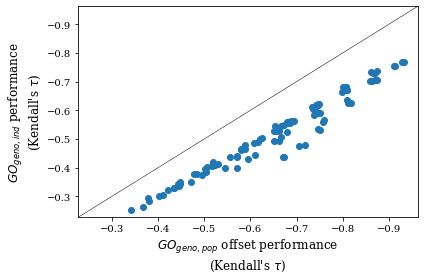

In [9]:
ax = plt.scatter(avg_perf, ind_perf)

draw_xy(ax.axes)

ax.axes.invert_yaxis()
ax.axes.invert_xaxis()

ax.axes.set_xlabel(f"{rt.factor_names['ind-avg']} offset performance\n(Kendall's $\\tau$)", fontsize=12)
ax.axes.set_ylabel(f"{rt.factor_names['ind']} performance\n(Kendall's $\\tau$)", fontsize=12)

plt.tight_layout()

### calc in parallel

In [10]:
jobs = []
for pkl in pkls:
    jobs.append(
        lview.apply_async(
            recalc_performance, pkl
        )
    )
    
watch_async(jobs)


Watching 1891 jobs ...


100%|███████████████| 1891/1891 [01:06<00:00, 28.28it/s]


### retrieve results

In [11]:
@timer
def annotate_jobs(jobs, idx=0):
    """Annotate the either of the two outputs from recalc_performance."""
    if idx == 0:
        source = 'ind-avg'
    else:
        source = 'ind'
    
    res = []
    for i, j in enumerate(pbar(jobs)):
        pkl = pkls[i]

        perf = j.r[idx].reset_index()

        perf.columns = ['garden', 'score']

        perf['seed'] = op.basename(pkl).split("_")[0]
        perf['num_loci'] = pkl.split("/")[6].lstrip('0')
        perf['rep'] = pkl.split("/")[5].split("_")[-1]

        res.append(perf)

    # combine
    _results = pd.concat(res).reset_index(drop=True)

    # add metadata
    for param in params.columns[-9:-1]:
        _results[param] = _results.seed.astype(str).map(params[param])

    _results['simulation_level'] = _results[_results.columns[6:]].apply(
        lambda x: '_'.join(x.astype(str)), axis=1
    )

    _results['offset_level'] = _results[['simulation_level', 'rep', 'num_loci', 'garden']].apply(
        lambda x: '_'.join(x.astype(str)), axis=1
    )

    _results.index = _results.offset_level.tolist()
    
    _results['source'] = source

    return _results


avg_results = annotate_jobs(jobs, idx=0)
ind_results = annotate_jobs(jobs, idx=1)

100%|███████████████| 1891/1891 [00:02<00:00, 760.36it/s]


Function `annotate_jobs` completed after : 0-00:00:22


100%|███████████████| 1891/1891 [00:02<00:00, 822.53it/s]


Function `annotate_jobs` completed after : 0-00:00:20


In [12]:
assert all(avg_results.index == ind_results.index)

### save 

no need to save `ind_results` since it's the same as what I have in `rt.load_results()["ind"]`

In [13]:
f = f'{fig_dir}/ind-averaged_results.txt'

avg_results.to_csv(f, sep='\t', index=False)  # index is offset_level column

f

'/work/lotterhos/brandon/runtime/figures/00_show_individual_averaging/ind-averaged_results.txt'

<a id='sanity'></a>
# sanity check

make sure my recalculated scores match the ones I already have saved

[top](#home)

In [23]:
# get previously saved individual-level results

# drop pop-level results
results = all_results[all_results.source == 'ind'].copy()
results.index = results.offset_level.tolist()

results

,garden,score,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,rep,num_loci,seed,demography,source,offset_level,seed_garden,final_la_bin
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_1,1,-0.561309,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,ind,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_1,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_2,2,-0.621278,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,ind,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_2,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_3,3,-0.681061,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,ind,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_3,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_4,4,-0.728768,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,ind,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_4,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_5,5,-0.755431,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,ind,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_5,0.42 < LA ≤ 0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_96,96,-0.350467,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,ind,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_96,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_97,97,-0.283708,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,ind,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_97,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_98,98,-0.234234,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,ind,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_98,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_99,99,-0.295184,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,ind,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_99,0.27 < LA ≤ 0.42


In [24]:
len(results.offset_level.unique())

189100

In [25]:
nrow(results)

189100

In [26]:
for method in ['pearson', 'spearman', 'kendall']:
    print(method, ind_results.loc[results.index].score.corr(results.score, method=method))

pearson 1.0
spearman 1.0
kendall 1.0


In [27]:
# how far in do I have to round until I get the same answer? A: 12 decimal places
for round_at in range(20):
    print(
        round_at, 
        all(ind_results.loc[results.index].score.round(round_at) == results.score.round(round_at))
    )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 False
14 False
15 False
16 False
17 False
18 False
19 False


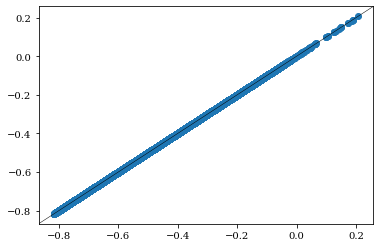

In [28]:
ax = plt.scatter(ind_results.loc[results.index].score, results.score)

draw_xy(ax.axes)

In [29]:
formatclock(dt.now() - t0)

'0-00:02:31'

In [30]:
avg_results.source.unique()

array(['ind-avg'], dtype=object)

In [31]:
ind_results.source.unique()

array(['ind'], dtype=object)